## Linear SVM

In [1]:
import helpers as helpers
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

from sklearn.metrics import *

from sklearn.model_selection import GridSearchCV, learning_curve
from scipy.special import expit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
MODEL_NAME = "linear"
DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"

In [3]:
data, labels = helpers.get_data(datapath=DEPRESSION_PATH, tokenize=False, by_character=False)

train_text, dev_text, test_text = helpers.split(data=data, dist=TDT_SPLIT)
train_dep, dev_dep, test_dep = helpers.split(data=labels, dist=TDT_SPLIT)

# Handles tokenization internally
model = CountVectorizer(max_features=50_000, ngram_range=(1,2), min_df=2)
model.fit(train_text)
train_vectors = model.transform(train_text)
dev_vectors = model.transform(dev_text)
test_vectors = model.transform(test_text)

# SVC expects normalized data, but it has a negligible effect
scaler = Normalizer(norm='l2')
scaler.fit(train_vectors)
train_vectors = scaler.transform(train_vectors)
dev_vectors = scaler.transform(dev_vectors)
test_vectors = scaler.transform(test_vectors)

Completing 80/10/10 split
Completing 80/10/10 split


In [4]:
# print(train_vectors.shape)
# total = 0
# for row in train_vectors:
#     total += sum(row.toarray())
# print(sum(total))

In [5]:
estimator = LinearSVC()

param_grid = {
    'penalty': ['l1', 'l2'],
    'tol': [.000005, .00001, .00005, .0001],
    'C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator, param_grid, scoring='f1', n_jobs=-1)


In [6]:
grid_search.fit(train_vectors, train_dep)

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/sit

,estimator,LinearSVC()
,param_grid,"{'C': [0.1, 1, ...], 'penalty': ['l1', 'l2'], 'tol': [5e-06, 1e-05, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [7]:
best_estimator = grid_search.best_estimator_

In [8]:
dev_predictions = best_estimator.predict(dev_vectors)

precision = precision_score(dev_dep, dev_predictions)
recall = recall_score(dev_dep, dev_predictions)
f1 = f1_score(dev_dep, dev_predictions)
accuracy = accuracy_score(dev_dep, dev_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.9712793733681462
Recall: 0.9489795918367347
F1: 0.96
Accuracy: 0.9598965071151359


In [9]:
best_estimator.score(test_vectors, test_dep)

0.958656330749354

PR-AUC: 0.9890487188265998
AUC Score: 0.987
Plot saved: results/linear/confusion_linear.png


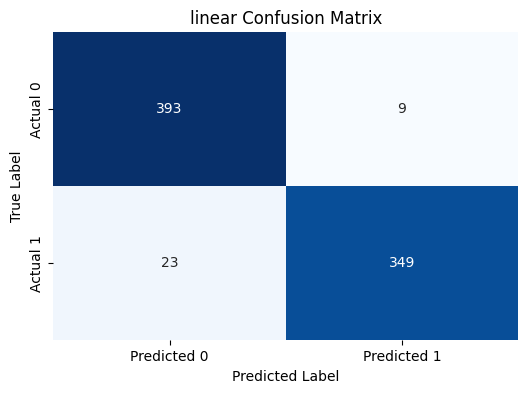

In [10]:
test_scores = best_estimator.decision_function(test_vectors)

# PR-AUC
test_probs = expit(test_scores)
precision_points, recall_points, _ = precision_recall_curve(test_dep, test_probs)
pr_auc = auc(recall_points, precision_points)
print(f"PR-AUC: {pr_auc}")

# ROC-AUC
fpr, tpr, thresholds = roc_curve(test_dep, test_scores)
auc_score = roc_auc_score(test_dep, test_scores)
print(f"AUC Score: {auc_score:.3f}")

# Confusion matrix
test_preds = grid_search.best_estimator_.predict(test_vectors)
cm = confusion_matrix(test_dep, test_preds)

# show cm
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{MODEL_NAME} Confusion Matrix')

# save graph
file_name = f"results/{MODEL_NAME}/confusion_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

Plot saved: results/linear/learning_curve_linear.png


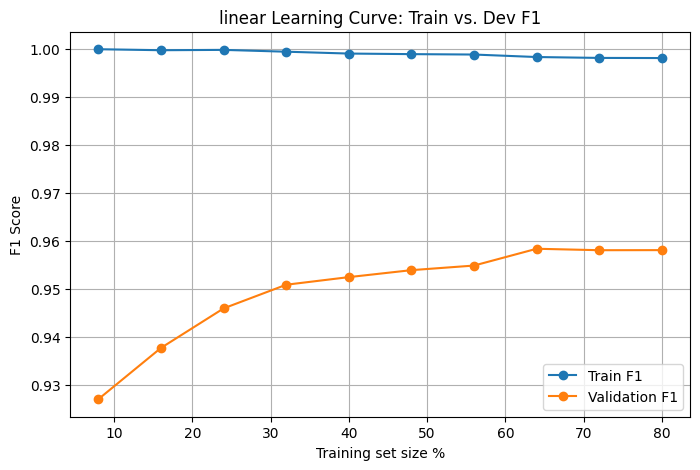

Plot saved: results/linear/pr_linear.png


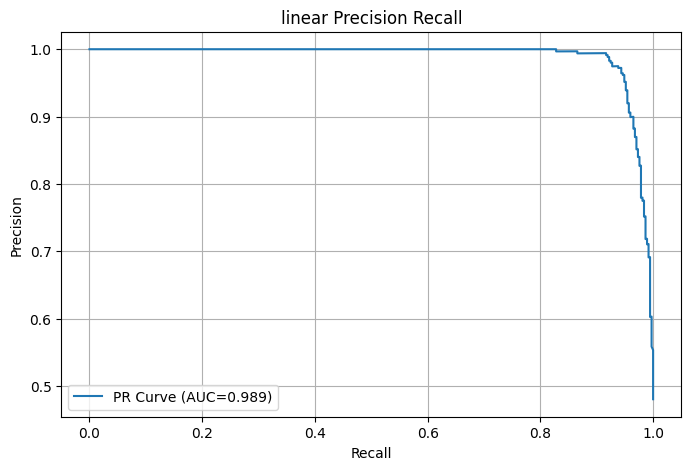

In [11]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_,
    train_vectors,
    train_dep,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes * 100 / train_vectors.shape[0], train_mean, marker='o', label='Train F1')
plt.plot(train_sizes * 100 / train_vectors.shape[0], test_mean, marker='o', label='Validation F1')
plt.xlabel('Training set size %')
plt.ylabel('F1 Score')
plt.title(f'{MODEL_NAME} Learning Curve: Train vs. Dev F1')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/learning_curve_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# PR graph
precision_points, recall_points, _ = precision_recall_curve(test_dep, test_probs)
pr_auc = auc(recall_points, precision_points)

plt.figure(figsize=(8,5))
plt.plot(recall_points, precision_points, label=f'PR Curve (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{MODEL_NAME} Precision Recall')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/pr_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

In [12]:
# lastly, save results to csv

csv_file_name = "results/results.csv"
row = [MODEL_NAME, precision, recall, f1, accuracy, pr_auc, auc_score]

helpers.save_to_csv(csv_file_name, row)

Data appended to results/results.csv


In [13]:
best = grid_search.best_estimator_
feature_names = model.get_feature_names_out()
coefficients = best.coef_[0]

k = 10
sorted_coef = np.sort(coefficients)

pos_indices = np.argsort(coefficients)[-k:][::-1]
pos_words = feature_names[pos_indices] # top k words MOST associated with depression

neg_indices = np.argsort(coefficients)[:k]
neg_words = feature_names[neg_indices] # top k words LEAST associated with depression

pos_words

array(['depression', 'anxiety', 'pression', 'die', 'title', 'scared',
       'kill', 'life', 'anymore', 'anxious'], dtype=object)